# GCM data from moose

In [144]:
%reload_ext autoreload

%autoreload 2

import os

import iris
import iris.analysis.cartography
import matplotlib.pyplot as plt
import metpy
import numpy as np
import xarray as xr

from ml_downscaling_emulator import UKCPDatasetMetadata
from ml_downscaling_emulator.utils import cp_model_rotated_pole, platecarree

In [145]:
moose_gcm_scratch_dir = os.path.join(os.getenv("SCRATCH_DATA"), "moose", "gcm")

example_gcm_xwind_path = os.path.join(moose_gcm_scratch_dir, "xwind198012.nc")

gcm_xwind = xr.open_dataset(example_gcm_xwind_path).sel(pressure=850.0)
gcm_xwind

<xarray.Dataset>
Dimensions:                  (time: 30, latitude: 325, longitude: 432, bnds: 2)
Coordinates:
  * time                     (time) object 1980-12-01 12:00:00 ... 1980-12-30...
    pressure                 float32 850.0
  * latitude                 (latitude) float32 -90.0 -89.44 ... 89.44 90.0
  * longitude                (longitude) float32 0.0 0.8333 ... 358.3 359.2
    forecast_period          (time) timedelta64[ns] ...
    forecast_reference_time  object ...
    realization              int32 ...
Dimensions without coordinates: bnds
Data variables:
    x_wind                   (time, latitude, longitude) float32 ...
    latitude_longitude       int32 ...
    time_bnds                (time, bnds) object ...
    forecast_period_bnds     (time, bnds) float64 ...
Attributes:
    source:       Data from Met Office Unified Model
    um_version:   10.4
    Conventions:  CF-1.7

In [146]:
example_gcm_ywind_path = os.path.join(moose_gcm_scratch_dir, "ywind198012.nc")

gcm_ywind = xr.open_dataset(example_gcm_ywind_path).sel(pressure=850.0)
gcm_ywind

<xarray.Dataset>
Dimensions:                  (time: 30, latitude: 325, longitude: 432, bnds: 2)
Coordinates:
  * time                     (time) object 1980-12-01 12:00:00 ... 1980-12-30...
    pressure                 float32 850.0
  * latitude                 (latitude) float32 -90.0 -89.44 ... 89.44 90.0
  * longitude                (longitude) float32 0.0 0.8333 ... 358.3 359.2
    forecast_period          (time) timedelta64[ns] ...
    forecast_reference_time  object ...
    realization              int32 ...
Dimensions without coordinates: bnds
Data variables:
    y_wind                   (time, latitude, longitude) float32 ...
    latitude_longitude       int32 ...
    time_bnds                (time, bnds) object ...
    forecast_period_bnds     (time, bnds) float64 ...
Attributes:
    source:       Data from Met Office Unified Model
    um_version:   10.4
    Conventions:  CF-1.7

In [147]:
example_cpm_xwind_path = os.path.join(os.getenv("SCRATCH_DATA"), "..", "data", "moose/uk/2.2km/rcp85/01/xwind/01/day/xwind_rcp85_land-cpm_uk_2.2km_01_day_19801201-19801230.nc")

cpm_xwind = xr.open_dataset(example_cpm_xwind_path)#.sel(pressure=850.0)
cpm_xwind

<xarray.Dataset>
Dimensions:                     (time: 30, pressure: 2, grid_latitude: 655,
                                 grid_longitude: 532, bnds: 2)
Coordinates:
  * time                        (time) object 1980-12-01 12:00:00 ... 1980-12...
  * pressure                    (pressure) float32 20.0 850.0
  * grid_latitude               (grid_latitude) float32 -5.565 -5.529 ... 8.945
  * grid_longitude              (grid_longitude) float32 353.1 353.1 ... 365.2
    forecast_period             (time) timedelta64[ns] ...
    forecast_reference_time     object ...
    realization                 int32 ...
Dimensions without coordinates: bnds
Data variables:
    x_wind                      (time, pressure, grid_latitude, grid_longitude) float32 ...
    rotated_latitude_longitude  int32 ...
    time_bnds                   (time, bnds) object ...
    grid_latitude_bnds          (grid_latitude, bnds) float32 ...
    grid_longitude_bnds         (grid_longitude, bnds) float32 ...
    forecast_period_bnds        (time, bnds) float64 ...
Attributes:
    source:       Data from Met Office Unified Model
    um_version:   10.6
    Conventions:  CF-1.7

In [157]:
dc = iris.load_cube(example_cpm_xwind_path).coords("grid_latitude")[0]

iris.load_cube(example_cpm_xwind_path).var_name

'x_wind'

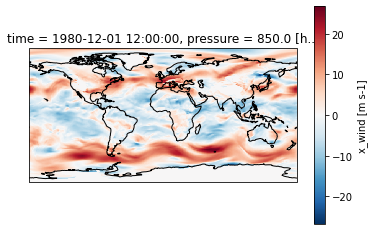

In [18]:
ax = plt.axes(projection=platecarree)
gcm_xwind['x_wind'].isel(time=0).plot(transform=platecarree)
ax.coastlines()


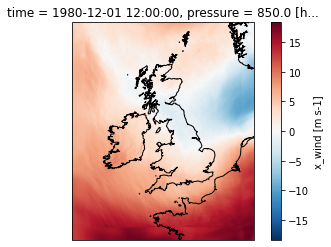

In [78]:
ax = plt.axes(projection=cp_model_rotated_pole)
cpm_xwind['x_wind'].isel(time=0).plot(transform=cp_model_rotated_pole)
ax.coastlines()

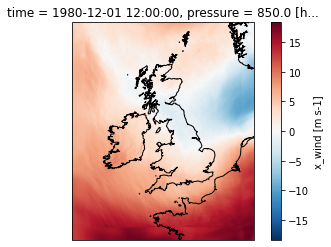

In [79]:
ax = plt.axes(projection=cp_model_rotated_pole)
cpm_xwind['x_wind'].isel(time=0).plot()
ax.coastlines()

In [25]:
cpm_xwind.grid_latitude_bnds.values.flatten()

array([-5.5827489e+00, -5.5467491e+00, -5.5467491e+00, ...,
        8.9268494e+00,  8.9268494e+00,  1.0737418e+09], dtype=float32)

In [49]:
rp_lat_lon_pairs = [(lat, long) for long in cpm_xwind.grid_longitude.values for lat in cpm_xwind.grid_latitude.values]
rp_lat_list = np.array([pair[0] for pair in rp_lat_lon_pairs])
rp_lon_list = np.array([pair[1] for pair in rp_lat_lon_pairs])
lons, lats = iris.analysis.cartography.unrotate_pole(rotated_lons=rp_lon_list, rotated_lats=rp_lat_list, pole_lon=177.5, pole_lat=37.5)

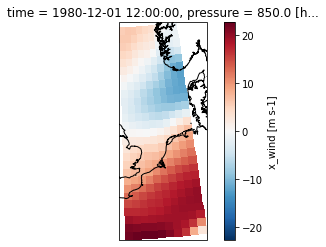

In [75]:
gcm_uk_xwind = gcm_xwind.sel(longitude=slice(lons.min(), lons.max()), latitude=slice(lats.min(), lats.max()))
ax = plt.axes(projection=cp_model_rotated_pole)
gcm_uk_xwind['x_wind'].isel(time=0).plot(transform=platecarree, ax=ax)
ax.coastlines()

## Try regrid to CPM 2.2km coarsened 27x

In [58]:
target_cube = iris.load_cube('../../src/ml_downscaling_emulator/utils/target-grids/2.2km-coarsened-27x/uk/moose_pr_grid.nc')
src_cube = iris.load_cube(example_gcm_xwind_path)
regridder = iris.analysis.Nearest().regridder(src_cube, target_cube)
regridded_da = xr.DataArray.from_iris(regridder(src_cube))

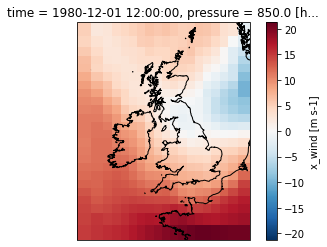

In [77]:
ax = plt.axes(projection=cp_model_rotated_pole)
regridded_da.isel(time=0).sel(pressure=850.0).plot(transform=cp_model_rotated_pole, ax=ax)
ax.coastlines()

In [61]:
regridded_da

<xarray.DataArray 'x_wind' (time: 30, pressure: 19, grid_latitude: 24,
                            grid_longitude: 19)>
dask.array<filled, shape=(30, 19, 24, 19), dtype=float32, chunksize=(10, 19, 24, 19), chunktype=numpy.ndarray>
Coordinates:
  * time                     (time) object 1980-12-01 12:00:00 ... 1980-12-30...
  * pressure                 (pressure) float32 1.0 5.0 10.0 ... 925.0 1e+03
  * grid_latitude            (grid_latitude) float32 -5.079 -4.139 ... 8.243
  * grid_longitude           (grid_longitude) float32 353.5 354.5 ... 364.0
    forecast_reference_time  object ...
    realization              int64 ...
    forecast_period          (time) timedelta64[ns] ...
Attributes:
    standard_name:  x_wind
    units:          m s-1
    source:         Data from Met Office Unified Model
    um_version:     10.4
    Conventions:    CF-1.7
    STASH:          m01s30i201
    cell_methods:   time: mean (interval: 1 hour)

## Try computing vorticity on global dataset before changing to target grid

In [99]:
import metpy.calc

/home/henry/anaconda3/envs/downscaling/lib/python3.9/site-packages/pint/quantity.py:1309: RuntimeWarning: invalid value encountered in true_divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)


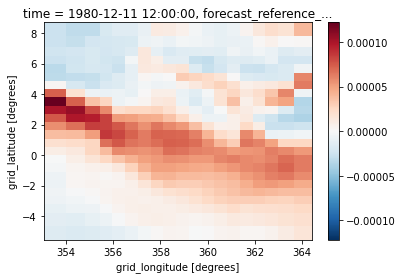

In [118]:
vort = metpy.calc.vorticity(gcm_xwind['x_wind'], gcm_ywind['y_wind'])
vort

vort_cube = vort.to_iris()
gcm_xwind_cube = iris.load_cube(example_gcm_xwind_path, constraint=iris.Constraint(pressure=850.0))
vort_cube.coords('longitude')[0].coord_system = iris.coord_systems.GeogCS(6371229.0)#gcm_xwind_cube.coords('longitude')[0].coord_system
vort_cube.coords('latitude')[0].coord_system = iris.coord_systems.GeogCS(6371229.0)#gcm_xwind_cube.coords('latitude')[0].coord_system

vort_regridder = iris.analysis.Nearest().regridder(vort_cube, target_cube)
xr.DataArray.from_iris(vort_regridder(vort_cube)).isel(time=10).plot()#.isel(grid_latitude=slice(10,20), grid_longitude=slice(5, 15), time=10).values

In [117]:
gcm_xwind_cube.coords('longitude')[0].coord_system

GeogCS(6371229.0)

In [119]:
target_cube.coords('grid_longitude')[0].coord_system

RotatedGeogCS(37.5, 177.5, ellipsoid=GeogCS(6371229.0))

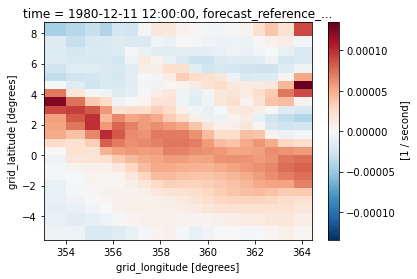

In [158]:
target_cube = iris.load_cube('../../src/ml_downscaling_emulator/utils/target-grids/2.2km-coarsened-27x/uk/moose_pr_grid.nc')
xwind_src_cube = iris.load_cube(example_gcm_xwind_path, constraint=iris.Constraint(pressure=850.0))
xwind_regridder = iris.analysis.Nearest().regridder(xwind_src_cube, target_cube)
xwind_regridded_da = xr.DataArray.from_iris(xwind_regridder(xwind_src_cube))

ywind_src_cube = iris.load_cube(example_gcm_ywind_path, constraint=iris.Constraint(pressure=850.0))
ywind_regridder = iris.analysis.Nearest().regridder(ywind_src_cube, target_cube)
ywind_regridded_da = xr.DataArray.from_iris(ywind_regridder(ywind_src_cube))

dx, dy =  metpy.calc.lat_lon_grid_deltas(xwind_regridded_da.grid_longitude.values, xwind_regridded_da.grid_latitude.values)
# make sure grid deltas broadcast properly over time dimension - https://stackoverflow.com/a/55012247
dx = dx[None, :]
dy = dy[None, :]

metpy.calc.vorticity(xwind_regridded_da, ywind_regridded_da, dx=dx, dy=dy).isel(time=10).plot()#.isel(grid_latitude=slice(10,20), grid_longitude=slice(5, 15), time=10)

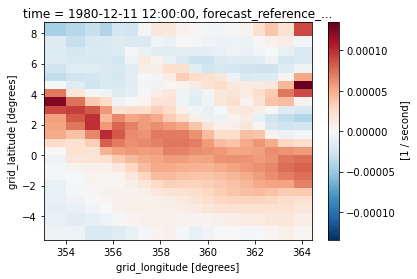

In [194]:
target_cube = iris.load_cube('../../src/ml_downscaling_emulator/utils/target-grids/2.2km-coarsened-27x/uk/moose_pr_grid.nc')

xwind_src_cube = gcm_xwind['x_wind'].to_iris()
xwind_src_cube.coords('longitude')[0].coord_system = iris.coord_systems.GeogCS(6371229.0)
xwind_src_cube.coords('latitude')[0].coord_system = iris.coord_systems.GeogCS(6371229.0)
xwind_regridder = iris.analysis.Nearest().regridder(xwind_src_cube, target_cube)
xwind_regridded_da = xr.DataArray.from_iris(xwind_regridder(xwind_src_cube))

ywind_src_cube = gcm_ywind['y_wind'].to_iris()
ywind_src_cube.coords('longitude')[0].coord_system = iris.coord_systems.GeogCS(6371229.0)
ywind_src_cube.coords('latitude')[0].coord_system = iris.coord_systems.GeogCS(6371229.0)
ywind_regridder = iris.analysis.Nearest().regridder(ywind_src_cube, target_cube)
ywind_regridded_da = xr.DataArray.from_iris(ywind_regridder(ywind_src_cube))

dx, dy =  metpy.calc.lat_lon_grid_deltas(xwind_regridded_da.grid_longitude.values, xwind_regridded_da.grid_latitude.values)
# make sure grid deltas broadcast properly over time dimension - https://stackoverflow.com/a/55012247
dx = dx[None, :]
dy = dy[None, :]

# ax = plt.axes(projection=rotated_pole)
metpy.calc.vorticity(xwind_regridded_da, ywind_regridded_da, dx=dx, dy=dy).isel(time=10).plot()# for just London/SE England: .isel(grid_longitude=slice(12, 17), grid_latitude=slice(5, 10))
# ax.coastlines()

## Multiple time slices

In [188]:
example_gcm_pr_path = os.path.join(os.getenv("MOOSE_DATA"), "global/60km/rcp85/01/pr/day/*.nc")

iris.load(example_gcm_pr_path)

[<iris 'Cube' of precipitation_flux / (kg m-2 s-1) (time: 360; latitude: 324; longitude: 432)>,
<iris 'Cube' of precipitation_flux / (kg m-2 s-1) (time: 360; latitude: 324; longitude: 432)>,
<iris 'Cube' of precipitation_flux / (kg m-2 s-1) (time: 360; latitude: 324; longitude: 432)>,
<iris 'Cube' of precipitation_flux / (kg m-2 s-1) (time: 360; latitude: 324; longitude: 432)>]

In [129]:
xr.open_mfdataset(example_gcm_pr_path)

<xarray.Dataset>
Dimensions:                  (time: 720, latitude: 324, longitude: 432, bnds: 2)
Coordinates:
  * time                     (time) object 1980-12-01 12:00:00 ... 2021-11-30...
  * latitude                 (latitude) float32 -89.72 -89.17 ... 89.17 89.72
  * longitude                (longitude) float32 0.4167 1.25 ... 358.7 359.6
    forecast_period          (time) timedelta64[ns] dask.array<chunksize=(360,), meta=np.ndarray>
    forecast_reference_time  object 1896-12-01 00:00:00
    realization              int32 1100000
Dimensions without coordinates: bnds
Data variables:
    precipitation_flux       (time, latitude, longitude) float32 dask.array<chunksize=(360, 324, 432), meta=np.ndarray>
    latitude_longitude       (time) int32 -2147483647 ... -2147483647
    time_bnds                (time, bnds) object dask.array<chunksize=(360, 2), meta=np.ndarray>
    forecast_period_bnds     (time, bnds) float64 dask.array<chunksize=(360, 2), meta=np.ndarray>
    precipitation_flux_0     (time, latitude, longitude) float32 dask.array<chunksize=(360, 324, 432), meta=np.ndarray>
Attributes:
    source:       Data from Met Office Unified Model
    um_version:   10.4
    Conventions:  CF-1.7

## Check processed data

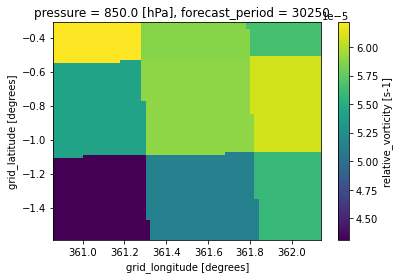

In [171]:
example_processed_gcm_vorticity_path = os.path.join(os.getenv("MOOSE_DERIVED_DATA"), "london/60km-2.2km/rcp85/01/vorticity850/day/vorticity850_rcp85_land-gcm_london_60km-2.2km_01_day_19801201-19811130.nc")

gcmvortregrid_ds = xr.open_dataset(example_processed_gcm_vorticity_path)

# ax = plt.axes(projection=cp_model_rotated_pole)
gcmvortregrid_ds["vorticity850"].isel(time=10).plot()#ax=ax)
# ax.coastlines()
# iris.load(example_processed_gcm_vorticity_path)

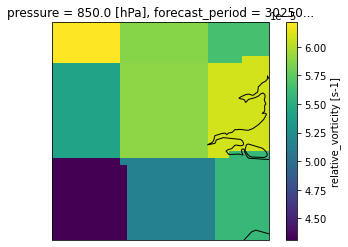

In [168]:
example_processed_gcm_vorticity_path = os.path.join(os.getenv("MOOSE_DERIVED_DATA"), "london/60km-2.2km-coarsened-2x/rcp85/01/vorticity850/day/vorticity850_rcp85_land-gcm_london_60km-2.2km-coarsened-2x_01_day_19801201-19811130.nc")

gcmvortregrid_ds = xr.open_dataset(example_processed_gcm_vorticity_path)
ax = plt.axes(projection=cp_model_rotated_pole)
gcmvortregrid_ds["vorticity850"].isel(time=10).plot(ax=ax)
ax.coastlines()

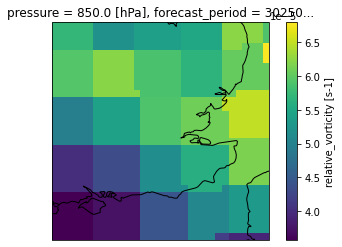

In [169]:
example_processed_gcm_vorticity_path = os.path.join(os.getenv("MOOSE_DERIVED_DATA"), "london/60km-2.2km-coarsened-4x/rcp85/01/vorticity850/day/vorticity850_rcp85_land-gcm_london_60km-2.2km-coarsened-4x_01_day_19801201-19811130.nc")

gcmvortregrid_ds = xr.open_dataset(example_processed_gcm_vorticity_path)
ax = plt.axes(projection=cp_model_rotated_pole)
gcmvortregrid_ds["vorticity850"].isel(time=10).plot(ax=ax)
ax.coastlines()


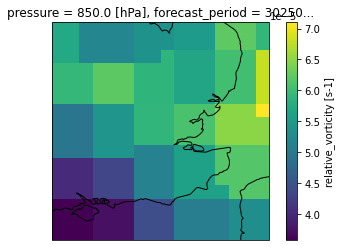

In [166]:
example_processed_gcm_vorticity_path = os.path.join(os.getenv("MOOSE_DERIVED_DATA"), "london/60km-2.2km-coarsened-8x/rcp85/01/vorticity850/day/vorticity850_rcp85_land-gcm_london_60km-2.2km-coarsened-8x_01_day_19801201-19811130.nc")

gcmvortregrid_ds = xr.open_dataset(example_processed_gcm_vorticity_path)
ax = plt.axes(projection=cp_model_rotated_pole)
gcmvortregrid_ds["vorticity850"].isel(time=10).plot(ax=ax)
ax.coastlines()
